# Combining weather (ERA5) with SAR-backscatter and WOfS

There are many conceivable applications where weather data (from gridded model reanalysis, essentially a best-available regular-interpolation of historical weather observations) is relevant to remote sensing imagery analysis, such as for selecting data for training and validation.

It is well documented (e.g. RSE 237 (2020) 111582) that "roughening of water surface due to rain and wind" increases the difficulty of discriminating water surfaces in radar backscatter images.

This notebook augments radar-backscatter (Sentinel 1) and optically-derived water-extents (WOfS), with windspeeds from ERA5.

## Loading radar and water layers

Lake George is an ephemeral lake. The first step here is to identify a period where radar imagery is available and the lake has water.

In [1]:
import datacube, numpy as np, matplotlib.pyplot as plt

In [2]:
sarcube = datacube.Datacube(config={'db_hostname': 'agdcdev-db.nci.org.au',
                                    'db_port': 6432,
                                    'db_database': 'radar_test'})
wofscube = datacube.Datacube()

In [3]:
lat, lon = -35.0862034,149.4188002 # lake george
e = 0.1

In [4]:
wofs = wofscube.load(product='wofs_albers', lat=(lat+e,lat-e), lon=(lon+e,lon-e))

In [5]:
radar = sarcube.load(product='s1_gamma0_scene', lat=(lat+e,lat-e), lon=(lon+e,lon-e))

In [6]:
wetness = (wofs.sel(time=slice('2010','2020')).water == 128).mean(dim=['x','y'])

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


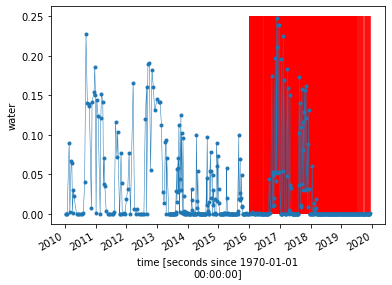

In [7]:
wetness.plot(marker='.', linewidth=0.5)
plt.vlines(radar.time.data, 0, 0.25, color='r')

(735964.0, 737060.0)

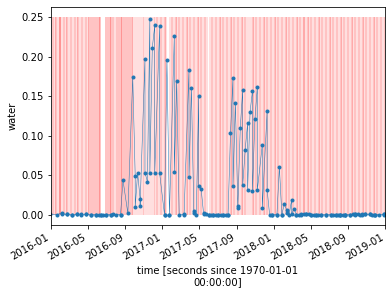

In [8]:
wetness.plot(marker='.', linewidth=0.5)
plt.vlines(radar.time.data, 0, 0.25, color='r', linewidth=0.25)
plt.xlim(['2016', '2019'])

(736238.0, 736420.0)

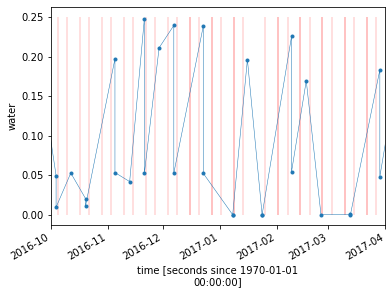

In [15]:
wetness.plot(marker='.', linewidth=0.5)
plt.vlines(radar.time.data, 0, 0.25, color='r', linewidth=0.25)
plt.xlim(['2016-10', '2017-04'])

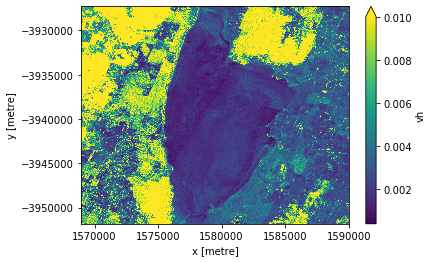

In [9]:
radar.vh.mean(dim='time').plot(vmax=0.01)

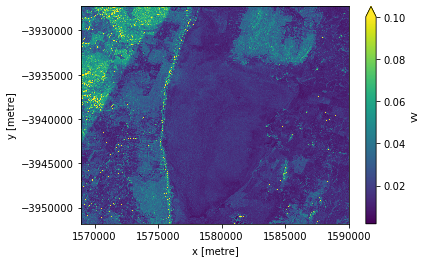

In [10]:
radar.vv.mean(dim='time').plot(vmax=0.1)

In [11]:
r = radar.vv.mean(dim='time')
g = radar.vh.mean(dim='time')
b = r+g

def normalise(band):
    return band/np.percentile(r, 98)

rgb = np.stack([normalise(r), normalise(g), normalise(b)], axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


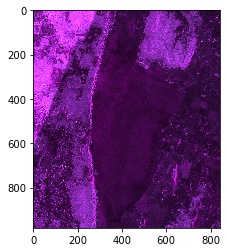

In [12]:
plt.imshow(rgb)

## Loading weather data

Since the climate data is gridded on a coarse resolution compared to the satellite imagery, only a single time series will be loaded.

The current method utilises data already available on the NCI, as this is currently also where the most radar data is available.

In [13]:
import glob, xarray

In [18]:
#files = (glob.glob('/g/data/ub4/era5/netcdf/surface/v10n/2016/*.nc') +
#         glob.glob('/g/data/ub4/era5/netcdf/surface/v10n/2017/*.nc') +
#         glob.glob('/g/data/ub4/era5/netcdf/surface/v10n/2018/*.nc'))
files = glob.glob('/g/data/ub4/era5/netcdf/surface/v10n/2017/*.nc')
datasets = [xarray.open_dataset(f).sel(latitude=lat, longitude=lon, method='nearest') for f in files]
v = xarray.concat(datasets, dim='time')

In [19]:
files = glob.glob('/g/data/ub4/era5/netcdf/surface/u10n/2017/*.nc')
datasets = [xarray.open_dataset(f).sel(latitude=lat, longitude=lon, method='nearest') for f in files]
u = xarray.concat(datasets, dim='time')

In [20]:
wind = xarray.merge([u,v])

In [21]:
wind['speed'] = (wind.u10n**2 + wind.v10n**2)**0.5

In [22]:
relevant = wind.sel(time=radar.time, method='nearest')

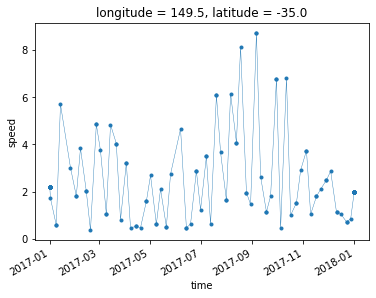

In [23]:
relevant.speed.plot(marker='.', linewidth=0.4)

In [124]:
relevant.time

<xarray.DataArray 'time' (time: 326)>
array(['2017-01-01T00:00:00.000000000', '2017-01-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', ..., '2017-12-31T23:00:00.000000000',
       '2017-12-31T23:00:00.000000000', '2017-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-12-31T23:00:00
    latitude   float32 -35.0
    longitude  float32 149.5
Attributes:
    long_name:  time

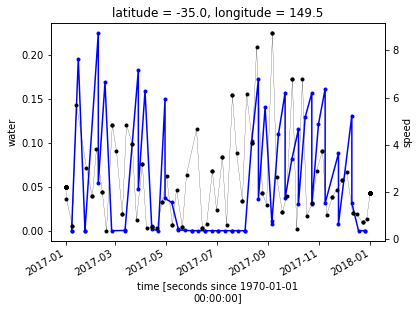

In [136]:
wetness.sel(time='2017').plot(color='b', marker='.')
relevant.speed.plot(color='k', marker='.', ax=plt.gca().twinx(), linewidth=0.2)

In [150]:
x = xarray.merge([radar, wind], join='inner', )

In [151]:
x

<xarray.Dataset>
Dimensions:    (time: 0, x: 843, y: 982)
Coordinates:
  * time       (time) datetime64[ns] 
  * y          (y) float64 -3.927e+06 -3.927e+06 ... -3.952e+06 -3.952e+06
  * x          (x) float64 1.569e+06 1.569e+06 1.569e+06 ... 1.59e+06 1.59e+06
    latitude   float32 -35.0
    longitude  float32 149.5
Data variables:
    vh         (time, y, x) float32 
    vv         (time, y, x) float32 
    lia        (time, y, x) float32 
    u10n       (time) float32 
    v10n       (time) float32 
    speed      (time) float32

In [141]:
len(radar.time.data)

326

In [144]:
len(np.unique(radar.time.data))

326

In [145]:
len(np.unique(relevant.time.data))

61

In [146]:
len(relevant.time.data)

326

In [148]:
list(zip(np.sort(relevant.time.data), np.sort(radar.time.data)))

[(numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-07T19:23:46.507857000')),
 (numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-07T19:24:11.508166000')),
 (numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-14T19:16:01.235771000')),
 (numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-19T19:23:46.221812000')),
 (numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-19T19:24:11.222140000')),
 (numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-26T19:16:00.789878000')),
 (numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-31T19:23:45.845757000')),
 (numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-31T19:23:45.845767000')),
 (numpy.datetime64('2017-01-01T00:00:00.000000000'),
  numpy.datetime64('2016-01-31T19:24:10.845421000')),
 (numpy.datetime64('2017-01-01T00:00: